Slide 1
<!--- ![](../reports/presentations/20231205/1.png) -->

# Pipeline

Slides 2-4
<!--- ![](../reports/presentations/20231205/2.png)
![](../reports/presentations/20231205/3.png)
![](../reports/presentations/20231205/4.png)--->

## Setup

### Imports

In [1]:
# External imports
import os
import sys
import spacy


# Get the current working directory (assuming the notebook is in the notebooks folder)
current_dir = os.getcwd()

# Add the parent directory (project root) to the Python path
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

# Relative imports
from src.utils import ld_spcy_mdl
from src.preprocess import Preprocessor
from src.modelling import get_constraints_from_data
from src.evaluation import cnstrnts_gs, sbert_smlarty, sbert_smlarty_cmpntns, evlt_prec_rec

/Users/leoh/Workspace/Anaconda/anaconda3/envs/nlp-rules/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Files

In [2]:
# Define variables to use as keys
aktg = "AktG"
cdm_01 = "CDM 01: A/R Mangroves"
cdm_02 = "CDM 02: A/R Non-wetlands"
cdm_03 = "CDM 03: Cable Cars"
cdm_04 = "CDM 04: Energy Efficiency"
cdm_05 = "CDM 05: Electriciy Generation"
coffee = "Coffee"
patg = "PatG"

# Define file paths
file_paths_input = {
    aktg: os.path.join('..', 'data', 'aktg', 'input_aktg.txt'),
    cdm_01: os.path.join('..', 'data', 'cdm', 'input_cdm_01.txt'),
    cdm_02: os.path.join('..', 'data', 'cdm', 'input_cdm_02.txt'),
    cdm_03: os.path.join('..', 'data', 'cdm', 'input_cdm_03.txt'),
    cdm_04: os.path.join('..', 'data', 'cdm', 'input_cdm_04.txt'),
    cdm_05: os.path.join('..', 'data', 'cdm', 'input_cdm_05.txt'),  
    coffee: os.path.join('..', 'data', 'coffee', 'input_coffee.txt'),
    patg: os.path.join('..', 'data', 'patg', 'input_patg.txt'),  
}

file_paths_output = {
    aktg: os.path.join('..', 'data', 'aktg', 'output_aktg.txt'),
    cdm_01: os.path.join('..', 'data', 'cdm', 'output_cdm_01.txt'),
    cdm_02: os.path.join('..', 'data', 'cdm', 'output_cdm_02.txt'),
    cdm_03: os.path.join('..', 'data', 'cdm', 'output_cdm_03.txt'),
    cdm_04: os.path.join('..', 'data', 'cdm', 'output_cdm_04.txt'),
    cdm_05: os.path.join('..', 'data', 'cdm', 'output_cdm_05.txt'),  
    coffee: os.path.join('..', 'data', 'coffee', 'output_coffee.txt'),
    patg: os.path.join('..', 'data', 'patg', 'output_patg.txt'),  
}

### Parameter

In [3]:
# spaCy model
model = 'en_core_web_lg'

# Load the spaCy model
nlp = ld_spcy_mdl(model=model)

# Define custom stop words
add_stpwrds = []
non_stpwrds = [
    "a",
    "above",
    "all",
    "amount",
    "and",
    "as",
    "at",
    "be",
    "before",
    "below",
    "between",
    "beyond",
    "both",
    "by",
    "can",
    "each",
    "either",
    "else",
    "even",
    "except",
    "for",
    "i",
    "if",
    "last",
    "least",
    "less",
    "may",
    "more",
    "most",
    "must",
    "name",
    "next",
    "no",
    "none",
    "not",
    "nothing",
    "of",
    "on",
    "only",
    "otherwise",
    "over",
    "or",
    "out",
    "per",
    "same", 
    "several",
    "should",
    "than",
    "then",
    "to",
    "under",
    "up",
    "what",
    "when",
    "with"
]

# This is needed because spaCy struggles with linebreak characters, but the information is needed for the enumeration (see also https://github.com/explosion/spaCy/issues/7735)
linebreak = " NEWLINE "

# Define character sequences to replace
replace = {
    ",": " , ", # Remove this line if any numbers with thousands (e.g. 1,000.00)
    "\n\n": "\n", 
    "\n \n": "\n",
    "\n \n\n": "\n",
    "\n\n \n": "\n",
    "\n": linebreak,
    "   ": " ",
    "  ": " "
} 

# Define character sequences to remove
remove=["\t"]

# Patterns for different enumeration items types for regex matching (to split into chunks)
enum_patterns = {
    'number_in_parentheses': r"\(\d+\)",
    'number_with_dot': r"\d+\.",
    'alphabetical_in_parentheses': r"\([a-z]\)",
    'roman_numeral_in_parentheses': r"\([ivxlcdm]+\)",
}

# Patterns for different enumeration items types for spaCy matching (to label enumeration tokens)
# Every pattern has to follow a linebreak; additionally, the order of the pattern has to be followed (e.g., "v" as alphabetical_in_parentheses can only be a match, if the previous one was also alphabetical_in_parentheses 
enum_patterns_spacy = {
    'number_in_parentheses': [{"TEXT": "("}, {"IS_DIGIT": True}, {"TEXT": ")"}],
    'number_with_dot': [{"IS_DIGIT": True}, {"TEXT": "."}, {"IS_DIGIT": False}],
    'alphabetical_in_parentheses': [{"TEXT": "("}, {"TEXT": {"IN": ["a", "b", "c", "d", "e", "f", "g", "h"]}}, {"TEXT": ")"}],
    'roman_numeral_in_parentheses': [{"TEXT": "("}, {"TEXT": {"IN": ["i", "ii", "iii", "iv", "v", "vi", "vii", "viii"]}}, {"TEXT": ")"}],
}

no_digit_or_period = [{"TEXT": {"NOT_IN": ["."]}, "IS_DIGIT": False, "OP": "*"}]

# Define inequality matching parameters
inequality_params = {
    "general": {
        "below": "<",
        "less than": "<",
        "low than": "<",
        "small than": "<",
        "as high as": "<=",
        "at most": "<=",
        "up to": "<=",
        "remain at": "<=",
        "eligibility limit of": "<=",
        "above": ">",
        "beyond": ">",
        "exceed": ">",
        "great than": ">",
        "high than": ">",
        "more than": ">",
        "surpass": ">",
        "at least": ">="
    },
    "exceptions": {
    },
    "exception_patterns": {
        # coffee
        "reach_beyond": [{"LOWER": "reach"}] + no_digit_or_period + [{"LIKE_NUM": True}] + no_digit_or_period + [{"LOWER": "beyond"}],
        "low_allow": [{"LOWER": "low"}] + no_digit_or_period + [{"LOWER": "allow"}] + no_digit_or_period + [{"LIKE_NUM": True}],
        "between": [{"LOWER": "between"}, {"LIKE_NUM": True}] + no_digit_or_period + [{"LIKE_NUM": True}],
        "brackets": [{"TEXT": "["}, {"LIKE_NUM": True}, {"IS_DIGIT": False, "OP": "?"},{"IS_DIGIT": False, "OP": "?"},{"IS_DIGIT": False, "OP": "?"},{"LIKE_NUM": True},{"IS_DIGIT": False, "OP": "*"}, {"TEXT": "]"}],
        "parentheses": [{"TEXT": "("}, {"LIKE_NUM": True}, {"IS_DIGIT": False, "OP": "?"},{"IS_DIGIT": False, "OP": "?"},{"IS_DIGIT": False, "OP": "?"},{"LIKE_NUM": True},{"IS_DIGIT": False, "OP": "*"}, {"TEXT": ")"}]
    },
    "negation_operators": {
        "<": ">=",
        "<=": ">",
        ">": "<=",
        ">=": "<"
    },
    "negation_tokens": {"not", "no"},
    "window_size": (12, 0) # Very long
}

# Define equality matching parameters
equality_params = {
    "general": {
        "must": "==",
        "shall": "==",
        "should": "=="
    },
    "exceptions": {
        # aktg
        "be to set out": "==",
        "applicable under": "==",
        # cdm_01
        "apply to": "==",
        # cdm_02
        "applicable to": "==",
        # cdm_03
        "eligible under": "==",
        # cdm_04
        "allowable project include": "==",
        # cdm_05
        "category comprise": "==",
        "include category": "==",
        "be limit to": "==",
        # patg
        "be to be": "=="
    },
    "exception_patterns": {
        # aktg
        "may_only": [{"LOWER": "may"}] + no_digit_or_period + [{"LOWER": "only"}],
        # cdm_01
        "fall_in": [{"LOWER": "fall"}] + no_digit_or_period + [{"LOWER": "category"}],
        # cdm_04
        "none_may": [{"LOWER": "none"}] + no_digit_or_period + [{"LOWER": "may"}],
    },
    "negation_operators": {
        "==": "!="
    },
    "negation_tokens": {"not", "no"},
    "window_size": (3, 2)
}

# Define meta matching parameters
# Due to the complex nature of the meta constraint searching process, some meta parametesr are also implicitly set within the MetaConstraintSearcher class
meta_params = {
    "enum_exceptions": {
        # cdm 02
        "be include": "OR",
        # cdm 05
        "at least one of": "OR"
    },
    "if_patterns": {
        "if_then": [{"LOWER": "if"}, {"TEXT": {"NOT_IN": [":",".",";"]}, "OP": "*"},{"TEXT": {"IN": [","]}, "OP": "?"}, {"LOWER": "then"}],
        "if_comma": [{"LOWER": "if"}, {"TEXT": {"NOT_IN": [":",".",";"]}, "OP": "*"},{"TEXT": {"IN": [","]}}, {"TEXT": {"NOT_IN": ["then"]}}],
        "if_case_of_comma": [{"LOWER": "case"}, {"LOWER": "of"}, {"TEXT": {"NOT_IN": [":",".",";"]}, "OP": "*"},{"TEXT": {"IN": [","]}}, {"TEXT": {"NOT_IN": ["then"]}}],
        
    },
    "for_patterns": {
        "for_colon": [{"LOWER": "for"}, {"TEXT": {"NOT_IN": [".",";",",", "for"]}, "OP": "*"},{"TEXT": {"IN": [":"]}}],
        "for_comma": [{"LOWER": "for"}, {"TEXT": {"NOT_IN": [":",".",";","for", ",", "---"]}, "OP": "*"},{"TEXT": {"IN": [","]}}, {"TEXT": {"NOT_IN": ["if"]}}]
    },
    "connectors": {
        "and": "AND",
        "and or": "OR",
        "or": "OR",
        "except when": "OR",
        # ";": "AND",
    },
    # Format is (pattern_name, matching_pattern): connector
    "connector_exception_pattern": {
        "semicolon": (";","AND")
    },
    "negation_tokens": {"not", "no"},   # Used for if_patterns
    "window_size": (0, 5),              # Used for if_patterns
    "context_limits": [".", ";"]
}

The model en_core_web_lg is already installed!


## Preprocessing

In [4]:
# Create preprocessing object
pp = Preprocessor(nlp, file_paths_input, verbose=False)

# Add and remove custom stop words globally to the spacy.util.get_lang_class('en')
stpwrds = pp.chng_stpwrds(add=add_stpwrds,remove=non_stpwrds, remove_numbers=True)

# Uncomment this line to restore the default set of stpwrds
# stpwrds = chng_stpwrds(restore_default=True, verbose=True)

# Process all files
data = pp.optimized_preprocessing(replace, remove, linebreak, enum_patterns, enum_patterns_spacy)

## Modelling

### Constraint Search

In [5]:
constraints = get_constraints_from_data(nlp, data, equality_params, inequality_params, meta_params, verbose=True)


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 

AKTG 

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 


++++ CHUNK ++++ 

establishment of by - law
 ( 1 ) by - law must be establish by way of be record by a notary

  id  type    match     pattern    exception    negation       symbol      level  predecessor    successor      context
----  ------  --------  ---------  -----------  -------------  --------  -------  -------------  -------------  ---------
   1  EQ      (11, 11)  MUST       False        (None, False)  ==              0  (0, 'START')   (2, 'FOLLOW')  (5, 21)

('STEP_4', 'CONSTRAINT')

++++ CHUNK ++++ 

authorised representative may act only if a power of attorney certify by a notary

  id  type    match    pattern    exception    negation       

In [6]:
constraints[aktg]

{'id': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50],
 'index': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'chunk': [0,
  1,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  4,
  4,
  5],
 'type': ['EQ',
  'EQ',
  'EQ',
  'META',
  'META',
  'META',
  'META',
  'META',
  'META',
  'META',
  'META',
  'META',
  'META',
  'META',
  'META',
  'META',
  'META',
  'META',


## Evaluation

In [7]:
constraints_dummy_cdm = {
    # Exact match
    "c1": "({check project type}, {check connection type}, {directly follows}, {project type == new installation OR project type == replacing existing fossil-fuel-fired generation})",
    # Close match
    "c2": "({check power plant type}, {check hydro power plant}, {directly follows}, {power plant type == hydro power})",
    # No match
    "c3": "({check combustion}, {check emissions}, {directly follows}, {fuel == coal})"
}
constraints_dummy_cdm = {
    'c1': '({check transport mode}, {check project type}, {directly follows}, {transport_mode == cable_car})',
    'c2': '({check project type}, {verify road accessibility}, {directly follows}, {project_type == new_construction})',
    'c3': '({verify road accessibility}, {assess fuel type}, {directly follows}, {accessibility == accessible_by_road})',
    'c4': '({assess fuel type}, {evaluate baseline scenario}, {directly follows}, {fuel_type in [electricity, gaseous_fossil, liquid_fossil, bio_fuel_blend]})',
    'c5': '({evaluate baseline scenario}, {check emission reduction measures}, {directly follows}, {baseline_scenario == represents_continuation_of_current_transport_system})',
    'c6': '({check emission reduction measures}, {apply methodology}, {directly follows}, {emission_reduction <= 60})'
}
constraints_dummy_cdm = constraints[cdm_01]["formatted"]

### Calculating similarity scores

In [10]:
# Transform content to dictionary
constraints_gs_cdm = cnstrnts_gs(file_paths_output[cdm_01])
constraints_gs_cdm

{'c1': '({check project activity}, {check habitat}, {directly follows}, {project_activity == afforestation OR project_activity == reforestation})',
 'c2': '({check habitat}, {check percentage of mangrove species}, {directly follows}, {land_type == degraded_mangrove_habitat})',
 'c3': '({check percentage of mangrove species}, {check soil disturbance attributable to project}, {directly follows}, {project_area_with_mangrove > 90})',
 'c4': '({check soil disturbance attributable to project}, {check compliance with applicability conditions of contained tools}, {directly follows}, {soil_disturbance_area <= 10})',
 'c5': '({check compliance with applicability conditions of contained tools}, {apply methodology}, {directly follows}, {comply_with_contained_tools == True})'}

In [11]:
similarity_scores = sbert_smlarty(constraints_dummy_cdm, constraints_gs_cdm, model='all-mpnet-base-v2')

for key, value in similarity_scores.items():
    print(f'{key}: {value}')

c1 - c1: 0.08485978841781616
c1 - c2: 0.11740364134311676
c1 - c3: 0.14326319098472595
c1 - c4: 0.18445739150047302
c1 - c5: 0.26216185092926025
c2 - c1: 0.07657510042190552
c2 - c2: 0.13988962769508362
c2 - c3: 0.16965800523757935
c2 - c4: 0.2182581126689911
c2 - c5: 0.2922218441963196
c3 - c1: 0.07163219898939133
c3 - c2: 0.12186744809150696
c3 - c3: 0.14102308452129364
c3 - c4: 0.24813751876354218
c3 - c5: 0.31743448972702026


In [18]:
matches_step_1, matches_step_2, matches_constraints = sbert_smlarty_cmpntns(similarity_scores, constraints_dummy_cdm, constraints_gs_cdm, threshold=0, model='paraphrase-MiniLM-L6-v2', matching_mode='unique')

In [19]:
matches_step_1

,Constraint pair,Group similarity,From,To,Similarity
0,c3 - c5,0.317434,STEP_9,check compliance with applicability conditions...,0.143385
1,c2 - c4,0.218258,STEP_8,check soil disturbance attributable to project,-0.021435
2,c1 - c3,0.143263,STEP_1,check percentage of mangrove species,0.010576


In [20]:
matches_step_2

,Constraint pair,Group similarity,From,To,Similarity
0,c3 - c5,0.317434,END,apply methodology,0.150269
1,c2 - c4,0.218258,STEP_9,check compliance with applicability conditions...,0.143385
2,c1 - c3,0.143263,STEP_8,check soil disturbance attributable to project,-0.021435


In [21]:
matches_constraints

,Constraint pair,Group similarity,From,To,Similarity
0,c3 - c5,0.317434,CONSTRAINT,comply_with_contained_tools == True,0.216562
1,c2 - c4,0.218258,CONSTRAINT,soil_disturbance_area <= 10,0.141812
2,c1 - c3,0.143263,CONSTRAINT,project_area_with_mangrove > 90,0.096787


### Calculating final score

Precision: 0.13486765225728353
Maximum precision: 1.0
Recall: 0.08092059135437012
Maximum recall: 0.6
Plot saved at: /Users/leoh/workspace/git/nlp-rule-extraction/notebooks/plots/precision_recall_curves_20240201_165909.png


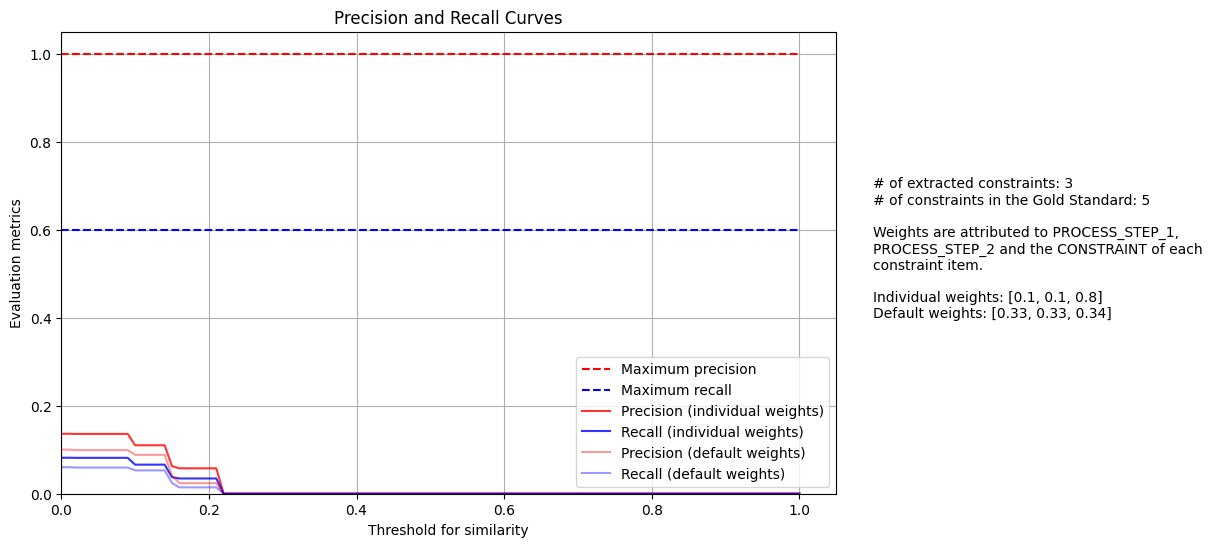

In [22]:
evlt_prec_rec(constraints_dummy_cdm, constraints_gs_cdm, matches_step_1, matches_step_2, matches_constraints, individual_weights=True, weights=[0.1, 0.1, 0.8], hard_cut=False, threshold=0.8, plot_curves=True)


![](../reports/presentations/20231205/5.png)
![](../reports/presentations/20231205/6.png)


![](../reports/presentations/20231205/7.png)